In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, AUC, Accuracy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.model_selection import train_test_split
from typing import Union

### load images

In [ ]:
datapath = '/content/drive/MyDrive/Images_face_classificator/data/'
train_female = datapath + "Female/"
train_male = datapath + "Male/"
test_male = datapath + "Test_Male/"
test_female = datapath +  "Test_Female/"

In [ ]:
height, width = (225, 225)

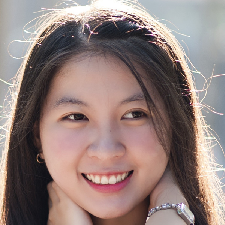

In [ ]:
i = os.listdir(train_female)[300]
load_img(train_female + i, target_size=(height, width), keep_aspect_ratio=True)

In [ ]:
def load_images(path: str, label: int) -> np.ndarray:
  """
    Loads images in path, resize them, convert to numpy and add labels to them
  """
  XC = np.array([
      img_to_array(load_img(path + i, target_size=(height, width), keep_aspect_ratio=True)) / 255
      for i in os.listdir(path)
    ])
  yC = np.array([label]*XC.shape[0])
  return (XC, yC)

In [ ]:
# call load_images to load female and male sets
X_train_female, y_train_female = load_images(path=train_female, label=1)
X_train_male, y_train_male = load_images(path=train_male, label=0)

X_test_female, y_test_female = load_images(path=test_female, label=1)
X_test_male, y_test_male = load_images(path=test_male, label=0)

In [ ]:
# create pre-train and pre-test from female and male sets
X_train_ = np.concatenate((X_train_female, X_train_male), axis=0)
y_train_ = np.concatenate((y_train_female, y_train_male), axis=0)
X_test = np.concatenate((X_test_female, X_test_male), axis=0)
y_test = np.concatenate((y_test_female, y_test_male), axis=0)

In [ ]:
# shuffle train and test sets
test_args = np.random.choice(y_train_.shape[0], int(y_train_.shape[0]*0.1), replace=False)
train_args = [i for i in range(y_train_.shape[0]) if i not in test_args]
np.random.shuffle(train_args)

In [ ]:
X_train, y_train = X_train_[train_args, :, :, :], y_train_[train_args]
X_eval, y_eval = X_train_[test_args, :, :, :], y_train_[test_args]

In [ ]:
y_train.shape, y_eval.shape

((963,), (107,))

### convert to tensor and batch it

In [ ]:
def tenconv(data:Union[np.ndarray, list]) -> tf.Tensor:
  """
  Function to convert to tensor. Build ontop of tf.convert_to_tensor
  Args:
    - data: numpy array or list of numpy arrays
  Returns:
    - tensorflow tensor from data
  """
  if isinstance(data, np.ndarray):
    return tf.convert_to_tensor(data, dtype=tf.float32)
  if isinstance(data, list):
    return [tf.convert_to_tensor(i, dtype=tf.float32) for i in data]

In [ ]:
# call tenconv to convert train, test and eval sets to tensors
X_train, y_train = tenconv([X_train, y_train])
X_test, y_test = tenconv([X_test, y_test])
X_eval, y_eval = tenconv([X_eval, y_eval])

In [ ]:
# convert to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_eval, y_eval))

In [ ]:
# divide by batchsize
batch_size = 12
train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=800)
test_dataset = test_dataset.batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)

### Model

In [ ]:
class GenderClassification(tf.keras.Model):
    def __init__(self):
        super().__init__()

        # Data augmentation layers
        self.augmentation = tf.keras.Sequential([
            preprocessing.RandomFlip("horizontal"),
            preprocessing.RandomRotation(0.1),
            preprocessing.RandomZoom(0.1)
        ])
        # Convolutional layers
        self.conv1 = Conv2D(10, (7, 7), activation='relu')
        self.maxpool1 = MaxPool2D((6, 6))
        self.conv2 = Conv2D(20, (7, 7), activation='relu')
        self.maxpool2 = MaxPool2D((6, 6))
        self.conv3 = Conv2D(32, (5, 5), activation='relu')
        self.flatten = Flatten()
        # Dense layers
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(1, activation='sigmoid')

    def call(self, inputs):
        # Apply data augmentation
        augmented_inputs = self.augmentation(inputs)
        # Apply convolutional layers
        x = self.conv1(augmented_inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        # Apply dense layers
        x = self.dense1(x)
        return self.dense2(x)


In [ ]:
# Instantiate the model
model = GenderClassification()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=["accuracy", AUC()]
)

In [ ]:
model.build((32, 225, 225, 3)) # necessary step to summarize the model

In [ ]:
model.summary()
# Note: the relevant number of paramters to take into consideration, 
# to avoid overfitting, is the total in the dense layers (2112)

Model: "gender_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 225, 225, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           multiple                  1480      
                                                                 
 max_pooling2d_6 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          multiple                  9820      
                                                                 
 max_pooling2d_7 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          multiple      

In [ ]:
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    # callbacks = [es, mc] # add callbacks later
)

Epoch 1/5
81/81 [==============================] - 1s 13ms/step - loss: 0.3389 - accuracy: 0.8505 - auc_3: 0.9231 - val_loss: 0.4043 - val_accuracy: 0.8037 - val_auc_3: 0.8869
Epoch 2/5
81/81 [==============================] - 1s 12ms/step - loss: 0.3691 - accuracy: 0.8432 - auc_3: 0.9079 - val_loss: 0.3732 - val_accuracy: 0.8224 - val_auc_3: 0.9012
Epoch 3/5
81/81 [==============================] - 1s 12ms/step - loss: 0.3343 - accuracy: 0.8525 - auc_3: 0.9232 - val_loss: 0.4115 - val_accuracy: 0.8037 - val_auc_3: 0.8795
Epoch 4/5
81/81 [==============================] - 1s 12ms/step - loss: 0.3293 - accuracy: 0.8411 - auc_3: 0.9260 - val_loss: 0.5052 - val_accuracy: 0.7944 - val_auc_3: 0.8535
Epoch 5/5
81/81 [==============================] - 1s 12ms/step - loss: 0.3378 - accuracy: 0.8463 - auc_3: 0.9220 - val_loss: 0.4094 - val_accuracy: 0.8318 - val_auc_3: 0.8836


### Analysis

In [ ]:
import matplotlib.pyplot as plt

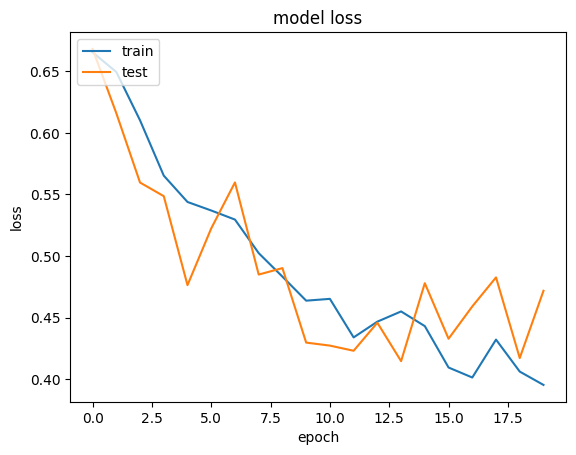

In [ ]:
# plot loss and metrics
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

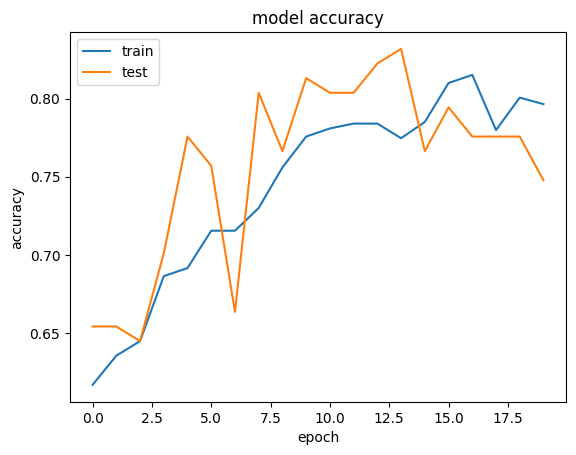

In [ ]:
# plot loss and metrics
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_dataset)

17/17 [==============================] - 0s 9ms/step - loss: 0.4704 - accuracy: 0.7750 - auc_3: 0.9047


[0.47042316198349, 0.7749999761581421, 0.9047499895095825]

### Save model weights

In [ ]:
model_path = '/content/drive/MyDrive/Images_face_classificator/Models/augmented_2/'

In [ ]:
model.save_weights(model_path + "simple_AUC_aug_7.h5")

In [ ]:
model.summary()

Model: "gender_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 225, 225, 3)       0         
                                                                 
 conv2d (Conv2D)             multiple                  1480      
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           multiple                  9820      
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           multiple        